# Capstone 3: A Scholarship Allocation Tool
**Summer camp participants apply for sholarship funding by submitting information about household income and financial need. The allocation tool uses this data to assign the applicant to a tier, determining the amount of support they receive.**

**Cost-of-living data come from MIT California living wage calculations:**
https://livingwage.mit.edu/states/06

# Data Wrangling
**Data:**
<br>**Applicant data** - includes household income and information about other financial need.
<br>**Cost-of-living data** - includes dollar figures for cost of living in Alameda County, California with figures for varying family sizes and age structures.

# 1. Import necessary libraries

In [64]:
# Import the libraries
import requests
import io
import pandas as pd
import numpy as np
import re

# 2. Scrape data from MIT cost of living site

In [2]:
#url for mit living wage, Alameda County, California
URL = "https://livingwage.mit.edu/counties/06001"
page = requests.get(URL)

#print(page.text)

#Read HTML tables into a list of DataFrame objects
df_list = pd.read_html(URL)

In [3]:
#get just the table with 'required annual income before taxes'
full_income_table = df_list[1]
#transpose table 
df_table = full_income_table.T
#make first row into column headers
df_table.columns = df_table.iloc[0]
#drop first row of text that is now column headers
df_table = df_table.iloc[1: , :]

df_table

('Unnamed: 0_level_0', 'Unnamed: 0_level_1')     Food Child Care Medical  \
1 ADULT                0 Children              $3,999         $0  $2,288   
                       1 Child                 $5,893    $14,718  $7,462   
                       2 Children              $8,853    $29,436  $7,249   
                       3 Children             $11,742    $44,154  $7,559   
2 ADULTS(1 WORKING)    0 Children              $7,332         $0  $5,764   
                       1 Child                 $9,124         $0  $7,249   
                       2 Children             $11,764         $0  $7,559   
                       3 Children             $14,321         $0  $7,347   
2 ADULTS(BOTH WORKING) 0 Children              $7,332         $0  $5,764   
                       1 Child                 $9,124    $14,718  $7,249   
                       2 Children             $11,764    $29,436  $7,559   
                       3 Children             $14,321    $44,154  $7,347   

('Unnamed: 0_level_0', 'Unnamed: 0_level_1')  Housing Transportation   Civic  \
1 ADULT                0 Children             $20,709         $4,938  $2,581   
                       1 Child                $30,941         $8,762  $4,144   
                       2 Children             $30,941        $11,391  $5,120   
                       3 Children             $41,497        $13,456  $6,686   
2 ADULTS(1 WORKING)    0 Children             $25,111         $8,762  $4,144   
                       1 Child                $30,941        $11,391  $5,120   
                       2 Children             $30,941        $13,456  $6,686   
                       3 Children             $41,497        $14,613  $5,314   
2 ADULTS(BOTH WORKING) 0 Children             $25,111         $8,762  $4,144   
                       1 Child                $30,941        $11,391  $5,120   
                       2 Children             $30,941        $13,456  $6,686   
                       3 Children             $41,497        $14,613  $5,314   

('Unnamed: 0_level_0', 'Unnamed: 0_level_1')   Other  \
1 ADULT                0 Children             $4,748   
                       1 Child                $7,080   
                       2 Children             $6,477   
                       3 Children             $9,424   
2 ADULTS(1 WORKING)    0 Children             $7,080   
                       1 Child                $6,477   
                       2 Children             $9,424   
                       3 Children             $9,115   
2 ADULTS(BOTH WORKING) 0 Children             $7,080   
                       1 Child                $6,477   
                       2 Children             $9,424   
                       3 Children             $9,115   

('Unnamed: 0_level_0', 'Unnamed: 0_level_1') Required annual income after taxes  \
1 ADULT                0 Children                                       $39,386   
                       1 Child                                          $79,124   
                       2 Children                                       $99,590   
                       3 Children                                      $134,640   
2 ADULTS(1 WORKING)    0 Children                                       $58,316   
                       1 Child                                          $70,426   
                       2 Children                                       $79,951   
                       3 Children                                       $92,331   
2 ADULTS(BOTH WORKING) 0 Children                                       $58,316   
                       1 Child                                          $85,144   
                       2 Children                                      $109,387   
                       3 Children                                      $136,485   

('Unnamed: 0_level_0', 'Unnamed: 0_level_1') Annual taxes  \
1 ADULT                0 Children                 $11,077   
                       1 Child         

In [4]:
#get table of adults, children and required annual income, save as a dataframe
df_income_table = pd.DataFrame(df_table['Required annual income before taxes'])
#move index values to columns
df_income_table = df_income_table.reset_index()
df_income_table.columns = ['num_adults_str', 'num_children_str', 'req_income_str']
#get integer values from string columns
df_income_table['num_adults'] = df_income_table['num_adults_str'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
df_income_table['num_children'] = df_income_table['num_children_str'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)
df_income_table['req_income_pretax'] = df_income_table['req_income_str'].astype('str').str.extractall('(\d+)').unstack().fillna('').sum(axis=1).astype(int)

print('2 ADULTS(1 WORKING) assumes second adult cares for children, it is not used in further calculations')
df_income_table


2 ADULTS(1 WORKING) assumes second adult cares for children, it is not used in further calculations


,num_adults_str,num_children_str,req_income_str,num_adults,num_children,req_income_pretax
0,1 ADULT,0 Children,"$50,463",1,0,50463
1,1 ADULT,1 Child,"$103,093",1,1,103093
2,1 ADULT,2 Children,"$129,759",1,2,129759
3,1 ADULT,3 Children,"$175,426",1,3,175426
4,2 ADULTS(1 WORKING),0 Children,"$75,982",21,0,75982
5,2 ADULTS(1 WORKING),1 Child,"$91,760",21,1,91760
6,2 ADULTS(1 WORKING),2 Children,"$104,171",21,2,104171
7,2 ADULTS(1 WORKING),3 Children,"$120,301",21,3,120301
8,2 ADULTS(BOTH WORKING),0 Children,"$75,982",2,0,75982
9,2 ADULTS(BOTH WORKING),1 Child,"$110,937",2,1,110937


### scraped values for model <a id='scraped'></a>
[link to model](#model)

In [5]:
# base income for 1 adult with no children
base_income = df_income_table['req_income_pretax'][0]
print('base income this year:                        ',base_income)

# calculate the cost of an additional child with one adult in household
one_child1 = df_income_table['req_income_pretax'][1] - df_income_table['req_income_pretax'][0]
two_child1 = df_income_table['req_income_pretax'][2] - df_income_table['req_income_pretax'][1]
three_child1 = df_income_table['req_income_pretax'][3] - df_income_table['req_income_pretax'][2]
avg_child1 = (one_child1+two_child1+three_child1)/3
#print('additional cost of one child:', one_child1)
#print('additional cost second child:', two_child1)
#print('additional cost third+ child:', three_child1)
#print('average cost additional child with one adult:', round(avg_child1,2))

# calculate the cost of an additional child with two adults in household
one_child2 = df_income_table['req_income_pretax'][9] - df_income_table['req_income_pretax'][8]
two_child2 = df_income_table['req_income_pretax'][10] - df_income_table['req_income_pretax'][9]
three_child2 = df_income_table['req_income_pretax'][11] - df_income_table['req_income_pretax'][10]
avg_child2 = (one_child2+two_child2+three_child2)/3
#print('additional cost of one child:', one_child2)
#print('additional cost second child:', two_child2)
#print('additional cost third+ child:', three_child2)
print('average cost additional child with two adults:', round(avg_child2,2))

# calculate the additional cost per child for a single parent
single_cost = avg_child1 - avg_child2
print('additional cost per child for single parent:  ', round(single_cost,2))

# calculate cost of additional adult
add_adult1 = df_income_table['req_income_pretax'][9] - df_income_table['req_income_pretax'][1]
add_adult2 = df_income_table['req_income_pretax'][10] - df_income_table['req_income_pretax'][2]
add_adult3 = df_income_table['req_income_pretax'][11] - df_income_table['req_income_pretax'][3]
avg_adult = (add_adult1+add_adult2+add_adult3)/3
#print('additional cost of adult, one child:', add_adult1)
#print('additional cost of adult, second child:', add_adult2)
#print('additional cost of adult, third+ child:', add_adult3)
print('average cost additional adult:                ', round(avg_adult,2))

# set values for additional household members
add_adult = avg_adult
add_child = avg_child2
#set default value for cost of additional circumstances
circumstance_cost = 5000
print('cost additional circumstance:                 ', circumstance_cost)

base income this year:                         50463
average cost additional child with two adults: 33949.67
additional cost per child for single parent:   7704.67
average cost additional adult:                 7671.33
cost additional circumstance:                  5000


# 3. Import application data

**Application questions:**
<br> Participant name.
<br> Guardiuan/contact name.
<br> What is your email address?
<br  What is your phone number?
<br> *What is your pre-tax household income, including any child support?
<br> *How many adults are supported on this income?
<br> *How many children are supported on this income?
<br> *Please include any notes on additional financial circumstances your family has experienced in the past year. (i.e. tuition expenses, medical expenses, moving, divorce, immigration, loss-of-employment, and more)

In [65]:
#get applicant data from your local file path
#application_data = pd.read_csv('/YOUR LOCAL PATH/fake_scholarship.csv')

#get publicly availbale applicant data from github
url = ('https://raw.githubusercontent.com/Floydworks/Capstone_3-R.Sandidge-/main/fake_scholarship.csv')
download = requests.get(url).content

# Read the downloaded content and turn it into a pandas dataframe
application_data = pd.read_csv(io.StringIO(download.decode('utf-8')))


In [66]:
application_data

,name,applied,household_income_pre_tax,number_adults,number_children,additional_expenses
0,a,yes,0,1,1,NaN
1,b,yes,0,1,1,NaN
2,c,yes,0,3,2,NaN
3,d,yes,0,2,2,NaN
4,e,yes,10000,1,2,NaN
...,...,...,...,...,...,...
65,ooo,yes,160000,1,2,NaN
66,ppp,yes,160000,2,3,NaN
67,qqq,yes,180000,3,4,NaN
68,rrr,yes,180000,2,2,NaN


# 4. Visualize household incomes from fake data and real data

In [50]:
import pandas as pd
import numpy as np
from sklearn import datasets
 
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
 
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.dpi'] = 100
 
from IPython.core.pylabtools import figsize

In [51]:
application_data = application_data[application_data['household_income_pre_tax'].notnull()]
application_data.head(3)

,name,applied,household_income_pre_tax,number_adults,number_children,additional_expenses
0,a,yes,0,1,1,NaN
1,b,yes,0,1,1,NaN
2,c,yes,0,3,2,NaN


Text(0.5, 1.0, 'household income of scholarship applicants\nfake data')

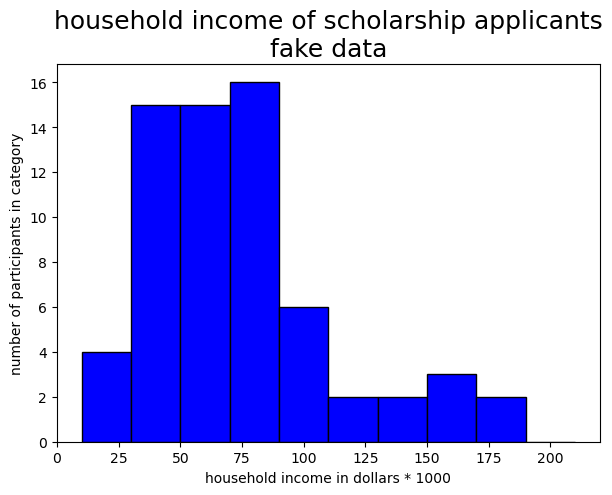

In [52]:
figsize(7, 5)
 
plt.hist(application_data['household_income_pre_tax']/1000, color='blue', edgecolor='black', 
         bins=[10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210])
 
plt.xlabel('household income in dollars * 1000')
plt.ylabel('number of participants in category')
plt.title('household income of scholarship applicants\nfake data', fontsize=18)

Text(0.5, 1.0, 'number of children per scholarship applicant household\nfake data')

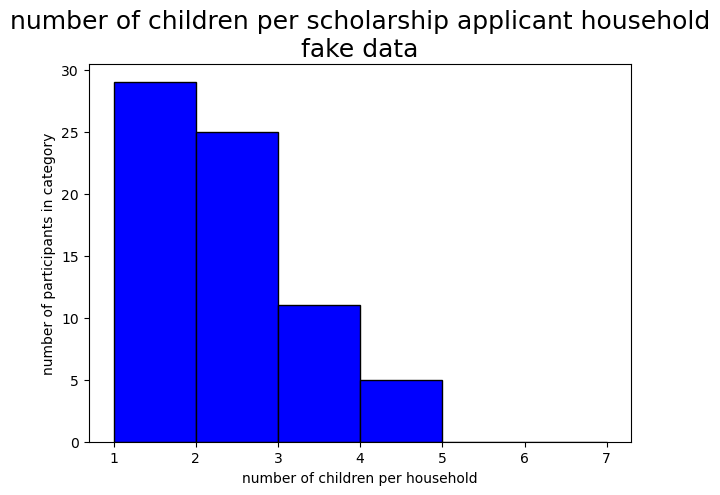

In [59]:
figsize(7, 5)
 
plt.hist(application_data['number_children'], color='blue', edgecolor='black', 
         bins=[1, 2, 3, 4, 5, 6, 7])
 
plt.xlabel('number of children per household')
plt.ylabel('number of participants in category')
plt.title('number of children per scholarship applicant household\nfake data', fontsize=18)

Text(0.5, 1.0, 'number of adults per scholarship applicant household\nfake data')

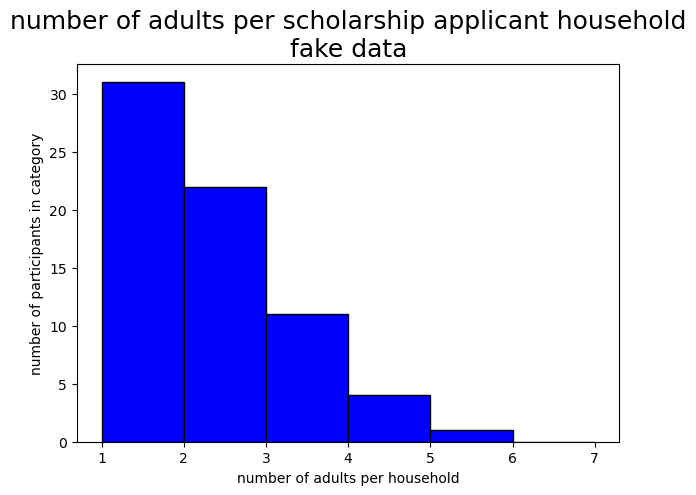

In [53]:
figsize(7, 5)
 
plt.hist(application_data['number_adults'], color='blue', edgecolor='black', 
         bins=[1, 2, 3, 4, 5, 6, 7])
 
plt.xlabel('number of adults per household')
plt.ylabel('number of participants in category')
plt.title('number of adults per scholarship applicant household\nfake data', fontsize=18)

In [54]:
#compare this with the real applicant info

real_incomes = pd.Series([30000.0,50000.0,26800.0,50000.0,102912.0,41000.0,90000.0,75000.0,40000.0,70000.0,80000.0,26500.0,
                50000.0,30000.0,80000.0,80000.0,50000.0,50000.0,40000.0,50000.0,45000.0,130000.0,40000.0,50000.0,
                15549.0,85000.0,80000.0,90000.0,160000.0,0.0,81000.0,137000.0,105000.0,30000.0,150000.0,105000.0,
                50000.0,50000.0])
real_adults = pd.Series([2,1,1,1,3,2,5,2,1,1,2,1,1,1,1,1,3,3,1,3,1,4,1,1,1,1,2,2,2,1,1,1,1,1,3,1,2,2])
real_children = pd.Series([3,1,1,1,1,2,2,4,1,1,2,1,1,1,1,2,3,3,1,1,1,1,3,1,1,2,2,3,2,2,1,1,2,1,2,2,3,3])

Text(0.5, 1.0, 'household income of scholarship applicants\n2019 - 2022')

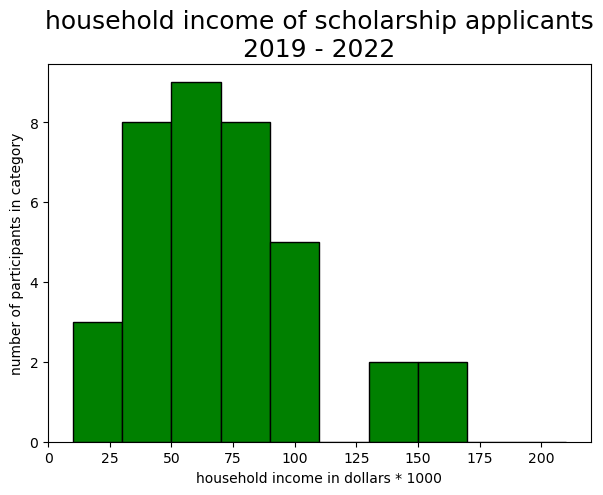

In [60]:
figsize(7, 5)
 
plt.hist(real_incomes/1000, color='green', edgecolor='black', 
         bins=[10, 30, 50, 70, 90, 110, 130, 150, 170, 190, 210])
 
plt.xlabel('household income in dollars * 1000')
plt.ylabel('number of participants in category')
plt.title('household income of scholarship applicants\n2019 - 2022', fontsize=18)

Text(0.5, 1.0, 'number of children per scholarship applicant household\n2019-2022')

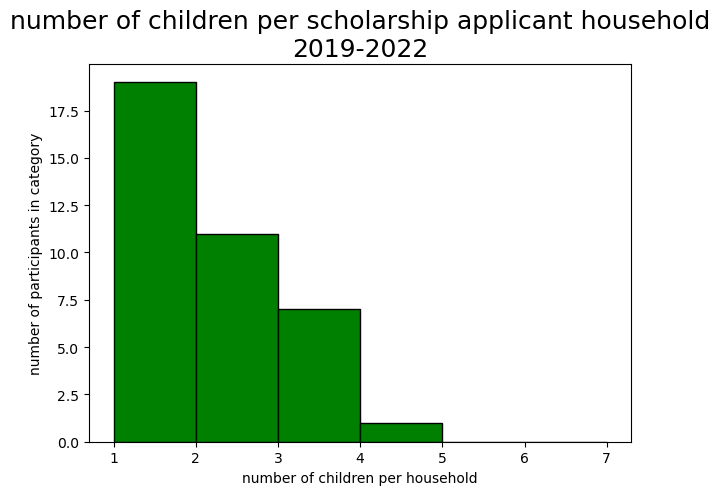

In [61]:
figsize(7, 5)
 
plt.hist(real_children, color='green', edgecolor='black', 
         bins=[1, 2, 3, 4, 5, 6, 7])
 
plt.xlabel('number of children per household')
plt.ylabel('number of participants in category')
plt.title('number of children per scholarship applicant household\n2019-2022', fontsize=18)

Text(0.5, 1.0, 'number of adults per scholarship applicant household\n2019-2022')

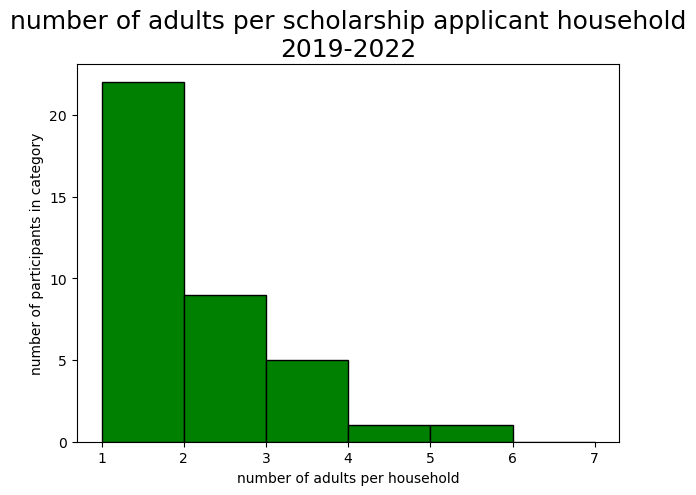

In [62]:
figsize(7, 5)
 
plt.hist(real_adults, color='green', edgecolor='black', 
         bins=[1, 2, 3, 4, 5, 6, 7])
 
plt.xlabel('number of adults per household')
plt.ylabel('number of participants in category')
plt.title('number of adults per scholarship applicant household\n2019-2022', fontsize=18)

# Data Wrangling Summary
<br>**MIT web data scraped**
<br>**applicant data is imported**
<br>**comparison of features with spread of the real data (not public)**